# Importación de librerías para conexión con la base de datos en PostgresSQL

In [1]:
import psycopg2
import pandas as pd
from dotenv import load_dotenv
import os
import numpy as np

# Importación de librerías para entrenamiento y evaluación de los modelos

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [34]:
from sklearn.metrics import f1_score, accuracy_score, recall_score, confusion_matrix

# Acceso a la base de datos de PostgresSQL

In [20]:
# Cargar las variables de entorno desde un archivo .env
load_dotenv()

# Obtener la URL de la base de datos desde las variables de entorno
DATABASE_URL = os.getenv("DATABASE_URL")

# Establecer una conexión a la base de datos
conn = psycopg2.connect(DATABASE_URL)

# Definir la consulta SQL para seleccionar todos los datos de la tabla "datos"
query = "SELECT * FROM datos"

# Utilizar pandas para ejecutar la consulta y cargar los resultados en un DataFrame
df = pd.read_sql_query(query, conn)

# Cerrar la conexión a la base de datos
conn.close()

# Ahora, df contiene los datos de la tabla "datos" en un DataFrame. Comprobamos la cantidad de registros
len(df)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_32116\1929048143.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


478

# Preparación de los datos para entrenar al modelo

In [21]:
# Definir una función para convertir la lista anidada en un numpy.ndarray
def parse_vector(vector_list):
    # Convertir la lista en un numpy.ndarray y luego redimensiona a (28, 28)
    return np.array(vector_list).reshape(28, 28).astype(np.float32)

# Aplicar la función a la columna "vector" y crea una nueva columna "VectorNum"
df['VectorNum'] = df['vector'].apply(parse_vector)

# Convertir la columna 'VectorNum' en una lista de numpy.ndarray
train_vectors = df['VectorNum'].to_list()

# Convertir la lista en un numpy.ndarray de forma (n, 28, 28), donde n es el número de filas
train_vectors = np.array(train_vectors)

labels = df['etiqueta'].tolist()
labels = np.array(labels)

# Entrenamiento de retrained_model.h5 únicamente con los datos extraídos de la app (alojados en tabla datos, en la db de PostrgresSQL)

In [5]:
# Crear un modelo secuencial
retrained_model = keras.Sequential([
    layers.Flatten(input_shape=(28, 28)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(10, activation='softmax')
])

# Compilar el modelo
retrained_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Entrenar el modelo
retrained_model.fit(np.array(train_vectors), labels, epochs=6)

Epoch 1/6
15/15 [==============================] - 2s 9ms/step - loss: 2.0147 - accuracy: 0.3695
Epoch 2/6
15/15 [==============================] - 0s 13ms/step - loss: 1.1751 - accuracy: 0.7323
Epoch 3/6
15/15 [==============================] - 0s 9ms/step - loss: 0.7398 - accuracy: 0.8274
Epoch 4/6
15/15 [==============================] - 0s 10ms/step - loss: 0.5420 - accuracy: 0.8938
Epoch 5/6
15/15 [==============================] - 0s 10ms/step - loss: 0.4519 - accuracy: 0.8894
Epoch 6/6
15/15 [==============================] - 0s 11ms/step - loss: 0.3797 - accuracy: 0.9115


In [6]:
# Una vez que haya terminado el entrenamiento, guardar el modelo
retrained_model.save("model_retrained.h5")

c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Reentrenamiento de mix_model.h5. Utiliza el model.h5 preentrenado con MNIST, y reentrena las últimas capas con los datos extraídos de la app

In [16]:
mnist_model = keras.models.load_model("model_mnist.h5")
mix_model = keras.models.clone_model(mnist_model)
mix_model.set_weights(mnist_model.get_weights())
for layer in mix_model.layers[:-4]: #entrena solamente las últimas 'n' capas
    layer.trainable = False

mix_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

mix_model.fit(np.array(train_vectors), labels, epochs=6)

Epoch 1/6
15/15 [==============================] - 2s 9ms/step - loss: 1.8555 - accuracy: 0.6903
Epoch 2/6
15/15 [==============================] - 0s 7ms/step - loss: 0.9227 - accuracy: 0.7788
Epoch 3/6
15/15 [==============================] - 0s 9ms/step - loss: 0.6816 - accuracy: 0.8252
Epoch 4/6
15/15 [==============================] - 0s 11ms/step - loss: 0.4254 - accuracy: 0.8761
Epoch 5/6
15/15 [==============================] - 0s 12ms/step - loss: 0.4176 - accuracy: 0.8982
Epoch 6/6
15/15 [==============================] - 0s 9ms/step - loss: 0.3230 - accuracy: 0.9181


In [18]:
# Una vez que haya terminado el entrenamiento, guardar el modelo
mix_model.save("model_mix.h5")

# Entrenamiento del modelo con conjunto de datos mnist

In [86]:
"""
# Cargar el conjunto de datos MNIST
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
# Normalizar los valores de píxeles al rango [0, 1]
train_images, test_images = train_images / 255.0, test_images / 255.0

# Crear un modelo secuencial
mnist_model = keras.Sequential([
    layers.Flatten(input_shape=(28, 28)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(10, activation='softmax')
])

# Compilar el modelo
mnist_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Entrenar el modelo
mnist_model.fit(np.array(train_images), train_labels, epochs=6)

# Una vez que haya terminado el entrenamiento, guardar el modelo
mnist_model.save("model_mnist.h5")
"""

Epoch 1/6
1875/1875 [==============================] - 24s 11ms/step - loss: 0.2962 - accuracy: 0.9146
Epoch 2/6
1875/1875 [==============================] - 26s 14ms/step - loss: 0.1412 - accuracy: 0.9583
Epoch 3/6
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1079 - accuracy: 0.9672
Epoch 4/6
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0880 - accuracy: 0.9725
Epoch 5/6
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0756 - accuracy: 0.9763
Epoch 6/6
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0657 - accuracy: 0.9790


***
# Comparativa de modelos
***

In [24]:
mnist_model = keras.models.load_model("model_mnist.h5")
mix_model = keras.models.load_model("model_mix.h5")
retrained_model = keras.models.load_model("model_retrained.h5")

# Cálculo de Accuracy

mnist_model

In [26]:
# Realiza las predicciones en el conjunto de entrenamiento
predictions = mnist_model.predict(train_vectors)
# Convierte las predicciones en etiquetas
predicted_labels = np.argmax(predictions, axis=1)
# Calcula la precisión
accuracy = np.mean(predicted_labels == labels)
print(f'Precisión del modelo en el conjunto de entrenamiento: {accuracy * 100:.2f}%')

15/15 [==============================] - 0s 4ms/step
Precisión del modelo en el conjunto de entrenamiento: 63.18%


mix_model

In [27]:
# Realiza las predicciones en el conjunto de entrenamiento
predictions = mix_model.predict(train_vectors)
# Convierte las predicciones en etiquetas
predicted_labels = np.argmax(predictions, axis=1)
# Calcula la precisión
accuracy = np.mean(predicted_labels == labels)
print(f'Precisión del modelo en el conjunto de entrenamiento: {accuracy * 100:.2f}%')

15/15 [==============================] - 0s 3ms/step
Precisión del modelo en el conjunto de entrenamiento: 94.77%


retrained_model

In [28]:
# Realiza las predicciones en el conjunto de entrenamiento
predictions = retrained_model.predict(train_vectors)
# Convierte las predicciones en etiquetas
predicted_labels = np.argmax(predictions, axis=1)
# Calcula la precisión
accuracy = np.mean(predicted_labels == labels)
print(f'Precisión del modelo en el conjunto de entrenamiento: {accuracy * 100:.2f}%')

15/15 [==============================] - 0s 4ms/step
Precisión del modelo en el conjunto de entrenamiento: 93.10%


# Cálculo de F1 Score

mnist_model

In [30]:
# Realiza las predicciones en el conjunto de entrenamiento
predictions = mnist_model.predict(train_vectors)
# Convierte las predicciones en etiquetas
predicted_labels = np.argmax(predictions, axis=1)
# Calcula el puntaje F1
f1 = f1_score(labels, predicted_labels, average='weighted')
print(f'Puntaje F1 en el conjunto de entrenamiento: {f1:.2f}')

15/15 [==============================] - 0s 4ms/step
Puntaje F1 en el conjunto de entrenamiento: 0.62


mix_model

In [31]:
# Realiza las predicciones en el conjunto de entrenamiento
predictions = mix_model.predict(train_vectors)
# Convierte las predicciones en etiquetas
predicted_labels = np.argmax(predictions, axis=1)
# Calcula el puntaje F1
f1 = f1_score(labels, predicted_labels, average='weighted')
print(f'Puntaje F1 en el conjunto de entrenamiento: {f1:.2f}')

15/15 [==============================] - 1s 5ms/step
Puntaje F1 en el conjunto de entrenamiento: 0.95


retrained_model

In [32]:
# Realiza las predicciones en el conjunto de entrenamiento
predictions = retrained_model.predict(train_vectors)
# Convierte las predicciones en etiquetas
predicted_labels = np.argmax(predictions, axis=1)
# Calcula el puntaje F1
f1 = f1_score(labels, predicted_labels, average='weighted')
print(f'Puntaje F1 en el conjunto de entrenamiento: {f1:.2f}')

15/15 [==============================] - 0s 3ms/step
Puntaje F1 en el conjunto de entrenamiento: 0.93


# Matriz de Confusión

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

mnist_model
***

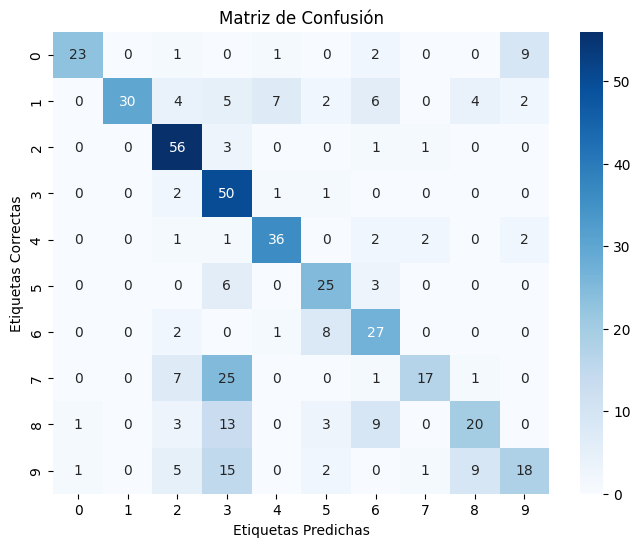

In [56]:
# Realiza las predicciones en el conjunto de entrenamiento
predictions = mnist_model.predict(train_vectors)
# Convierte las predicciones en etiquetas
predicted_labels = np.argmax(predictions, axis=1)
# Calcula la matriz de confusión
confusion = confusion_matrix(labels, predicted_labels)
# Define los nombres de las etiquetas
class_names = [str(i) for i in range(10)]
# Crea un heatmap para visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Etiquetas Predichas')
plt.ylabel('Etiquetas Correctas')
plt.title('Matriz de Confusión')
plt.show()

In [59]:
value_to_count = [0,1,2,3,4,5,6,7,8,9]
for value_to_count in value_to_count:
    count_a = np.count_nonzero(labels == value_to_count)
    count_b = np.count_nonzero(predicted_labels == value_to_count)
    print(f"Valor {value_to_count}. {count_a} labels. {count_b} predicted_labels.")

Valor 0. 36 labels. 25 predicted_labels.
Valor 1. 60 labels. 30 predicted_labels.
Valor 2. 61 labels. 81 predicted_labels.
Valor 3. 54 labels. 118 predicted_labels.
Valor 4. 44 labels. 46 predicted_labels.
Valor 5. 34 labels. 41 predicted_labels.
Valor 6. 38 labels. 51 predicted_labels.
Valor 7. 51 labels. 21 predicted_labels.
Valor 8. 49 labels. 34 predicted_labels.
Valor 9. 51 labels. 31 predicted_labels.


mix_model
***

15/15 [==============================] - 1s 7ms/step


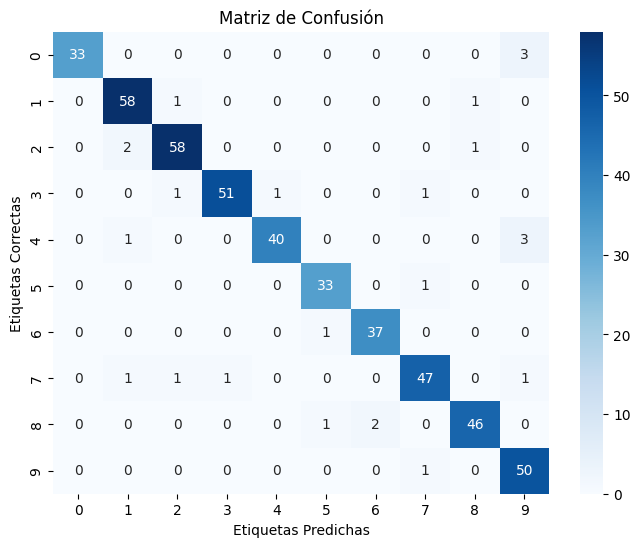

In [60]:
# Realiza las predicciones en el conjunto de entrenamiento
predictions = mix_model.predict(train_vectors)
# Convierte las predicciones en etiquetas
predicted_labels = np.argmax(predictions, axis=1)
# Calcula la matriz de confusión
confusion = confusion_matrix(labels, predicted_labels)
# Define los nombres de las etiquetas
class_names = [str(i) for i in range(10)]
# Crea un heatmap para visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Etiquetas Predichas')
plt.ylabel('Etiquetas Correctas')
plt.title('Matriz de Confusión')
plt.show()

In [61]:
value_to_count = [0,1,2,3,4,5,6,7,8,9]
for value_to_count in value_to_count:
    count_a = np.count_nonzero(labels == value_to_count)
    count_b = np.count_nonzero(predicted_labels == value_to_count)
    print(f"Valor {value_to_count}. {count_a} labels. {count_b} predicted_labels.")

Valor 0. 36 labels. 33 predicted_labels.
Valor 1. 60 labels. 62 predicted_labels.
Valor 2. 61 labels. 61 predicted_labels.
Valor 3. 54 labels. 52 predicted_labels.
Valor 4. 44 labels. 41 predicted_labels.
Valor 5. 34 labels. 35 predicted_labels.
Valor 6. 38 labels. 39 predicted_labels.
Valor 7. 51 labels. 50 predicted_labels.
Valor 8. 49 labels. 48 predicted_labels.
Valor 9. 51 labels. 57 predicted_labels.


retrained_model
***

15/15 [==============================] - 0s 4ms/step


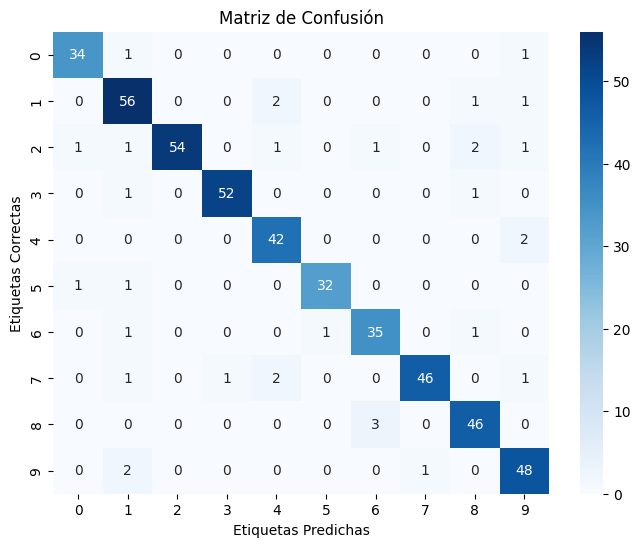

In [63]:
# Realiza las predicciones en el conjunto de entrenamiento
predictions = retrained_model.predict(train_vectors)
# Convierte las predicciones en etiquetas
predicted_labels = np.argmax(predictions, axis=1)
# Calcula la matriz de confusión
confusion = confusion_matrix(labels, predicted_labels)
# Define los nombres de las etiquetas
class_names = [str(i) for i in range(10)]
# Crea un heatmap para visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Etiquetas Predichas')
plt.ylabel('Etiquetas Correctas')
plt.title('Matriz de Confusión')
plt.show()

In [64]:
value_to_count = [0,1,2,3,4,5,6,7,8,9]
for value_to_count in value_to_count:
    count_a = np.count_nonzero(labels == value_to_count)
    count_b = np.count_nonzero(predicted_labels == value_to_count)
    print(f"Valor {value_to_count}. {count_a} labels. {count_b} predicted_labels.")

Valor 0. 36 labels. 36 predicted_labels.
Valor 1. 60 labels. 64 predicted_labels.
Valor 2. 61 labels. 54 predicted_labels.
Valor 3. 54 labels. 53 predicted_labels.
Valor 4. 44 labels. 47 predicted_labels.
Valor 5. 34 labels. 33 predicted_labels.
Valor 6. 38 labels. 39 predicted_labels.
Valor 7. 51 labels. 47 predicted_labels.
Valor 8. 49 labels. 51 predicted_labels.
Valor 9. 51 labels. 54 predicted_labels.
